# 02 - Latent Semantic Analysis (LSA)
This notebook performs Latent Semantic Analysis on the governance data set. It assumes the data was cleaned and placed in the cache by the "Explore the Governance Data Set" notebook.

We start out by replicating the steps that Joshua Cook shows in his [Introduction to Latent Semantic Analysis](https://www.youtube.com/playlist?list=PLroeQp1c-t3qwyrsq66tBxfR6iX6kSslt) youtube series. Although we follow his examples, we renamed a few things, graphed some of it and wrap results in a Pandas data frame for readability and easy handling. From there we apply the same to out governance data set. It starts off pretty similar to our earlier notebook that performs a TF-IDF analysis of the documents.

---
## Dependencies and Imports
Here we import the libraries we need to perform our analysis.

In [166]:
!pip install scikit-learn pandas seaborn graphviz

In [167]:
import re
import sys
from pathlib import Path
print("python=={}".format(re.sub(r'\s.*', '', sys.version)))

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import __version__ as sklearn__version__
print(f"scikit-learn=={sklearn__version__}")

import pandas as pd
print(f"pandas=={pd.__version__}")
ROW    = 0
COLUMN = 1
STRING = 'string'
OBJECT = 'object'
NUMBER = 'number'
CATEGORY = 'category'
INTEGER = 'integer'
UNSIGNED = 'unsigned'
FLOAT = 'float'

import matplotlib.pyplot as plt
from matplotlib import __version__ as matplotlib__version__
print(f"matplotlib=={matplotlib__version__}")

import seaborn as sns
CMAP_VLAG = sns.color_palette("vlag", as_cmap=True)
print(f"seaborn=={sns.__version__}")

from graphviz import __version__ as graphviz__version__
print(f"graphviz=={graphviz__version__}")
from graphviz import Source as dot_graph


python==3.10.4
scikit-learn==1.1.1
pandas==1.5.3
matplotlib==3.5.1
seaborn==0.11.2
graphviz==0.20.1


---
## Replicate Joshua Cook's Examples
Joshua starts with a trivial set of documents, represented here by strings in a Pandas data frame.

It may seem a bit odd to use the text as both the index and the body of the data frame. This will become clear below when we need to know what term came from what document.

In [168]:
trivial_body = [
    "the quick brown fox",
    "the slow brown dog",
    "the quick red dog",
    "the lazy yellow fox"
]

trivial_corpus = pd.DataFrame(data=trivial_body, index=trivial_body, columns=["body"])
trivial_corpus

,body
the quick brown fox,the quick brown fox
the slow brown dog,the slow brown dog
the quick red dog,the quick red dog
the lazy yellow fox,the lazy yellow fox


### Document-Term Matrix
Using a count vectorizer he calculates what he calls the document-term matrix. He also uses the term "bag of words", but in this notebook we use the name document-term matrix for precision.

We won't use it on the trivial corpus, but I added the `min_df` parameter for use with the governance data set, later on. That parameter helped a lot to get better results and I expect we will use it again.

Below is a schematic view of the step we are about to take.

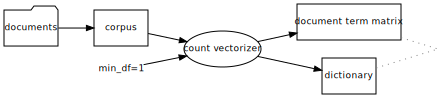

In [169]:
dot_graph('''
digraph {
  rankdir=LR;
  node [fontname="georgia; serif" fontsize=9, margin=0 arrowhead=normal arrowtail=dot];
  edge [arrowsize=0.75]

  node [shape=folder]; documents;
  node [shape=oval]; vec [label="count vectorizer"];
  node [shape=plain]; min_df [label="min_df=1"]; dot0 [label=" "];
  node [shape=box]; dtm [label="document term matrix"]; dict [label="dictionary"];

  documents -> corpus;
  min_df -> vec;
  corpus -> vec;
  vec -> dtm;
  vec -> dict;
  dtm -> dot0 [color=grey style=dotted arrowhead=none arrowsize=0.5];
  dict -> dot0 [color=grey style=dotted arrowhead=none arrowsize=0.5];
}
''')


In [170]:
# the caller is expected to select the right column from their data frame and
# pass it in as a series.
def compose_document_term_matrix_by_count(series, min_df=1):
    vectorizer = CountVectorizer(min_df=min_df)
    dt_matrix  = vectorizer.fit_transform(series)
    dictionary = vectorizer.get_feature_names_out()

    return pd.DataFrame(index=series.index, columns=dictionary, data=dt_matrix.toarray()), \
           dictionary


In [171]:
trivial_document_term_matrix, trivial_dictionary = compose_document_term_matrix_by_count(trivial_corpus['body'])
trivial_document_term_matrix


,brown,dog,fox,lazy,quick,red,slow,the,yellow
the quick brown fox,1,0,1,0,1,0,0,1,0
the slow brown dog,1,1,0,0,0,0,1,1,0
the quick red dog,0,1,0,0,1,1,0,1,0
the lazy yellow fox,0,0,1,1,0,0,0,1,1


### Singular Value Decomposition (SVD)
Singular value decomposition (SVD) encodes our corpus into topic encoded data. Instead of feeding it our text corpus, SVD relies on the document-term matrix produced by the count vectorizer above. We use the text corpus only as index so the resulting Pandas data frame is readable. The algorithm relies on the document-term matrix alone.

To make it easier to determine what a topic is about, the LSA function below also returns a encoding matrix based on the dictionary from the count vectorizer.

Using the same, trivial corpus nicely shows a distinction between the documents talking about dogs (shown as "topic 0") and foxes (as "topic 1").


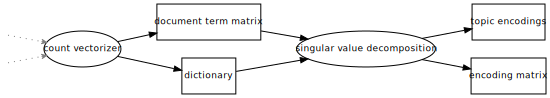

In [172]:
dot_graph('''
digraph {
  rankdir=LR;
  node [fontname="georgia; serif" fontsize=9, margin=0 arrowhead=normal arrowtail=dot];
  edge [arrowsize=0.75]

  node [shape=plain label=" "]; dot0; dot1;
  node [shape=oval]; vec [label="count vectorizer"]; svd [label="singular value decomposition"];
  node [shape=box]; dtm [label="document term matrix"]; dict [label="dictionary"]; topic_enc [label="topic encodings"];
    enc_mtx [label="encoding matrix"];

  dot0 -> vec [color=grey style=dotted arrowhead=vee arrowsize=0.5];
  dot1 -> vec [color=grey style=dotted arrowhead=vee arrowsize=0.5];
  vec -> dtm;
  vec -> dict;
  dtm -> svd;
  dict -> svd;
  svd -> topic_enc;
  svd -> enc_mtx;
}
''')


In [173]:
def perform_lsa(dt_matrix, dictionary, n_components=2):
    svd = TruncatedSVD(n_components=n_components)
    lsa = svd.fit_transform(dt_matrix)
    topics = [f"topic {n}" for n in range(lsa.shape[1])]

    return pd.DataFrame(index=dt_matrix.index, data=lsa, columns=topics), \
           pd.DataFrame(index=topics, data=svd.components_, columns=dictionary).T


In [174]:
trivial_topic_encodings, trivial_encoding_matrix = perform_lsa(trivial_document_term_matrix, trivial_dictionary)
trivial_topic_encodings


,topic 0,topic 1
the quick brown fox,1.694905,0.299524
the slow brown dog,1.515851,-0.769110
the quick red dog,1.515851,-0.769110
the lazy yellow fox,1.266186,1.440585


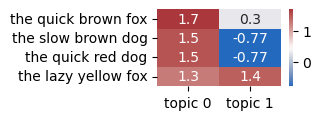

In [175]:
plt.figure(figsize=(2, 1))
sns.heatmap(trivial_topic_encodings, annot=True, cmap=CMAP_VLAG);


In [176]:
trivial_encoding_matrix


,topic 0,topic 1
brown,0.353937,-0.140256
dog,0.334199,-0.459436
fox,0.326416,0.519736
lazy,0.139578,0.430274
quick,0.353937,-0.140256
red,0.167100,-0.229718
slow,0.167100,-0.229718
the,0.660615,0.060300
yellow,0.139578,0.430274


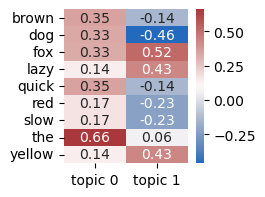

In [177]:
plt.figure(figsize=(2, 2))
sns.heatmap(trivial_encoding_matrix, annot=True, cmap=CMAP_VLAG);


In his code, Joshua takes the absolute values of the topic columns. In his presentation he suggests that we should be looking for the strongest correlations, either negative or positive. Instead of adding columns, we take the absolute value on the fly as we search for the $n$ most significant terms. We don't preserve the absolute values, since they are not needed after selection.

Based on the heatmap above, "topic 1" seems to be based around the type of animal. It has a strong correlation with "fox" and a strong negative correlation with "dog". This is further supported by selecting the most significant terms as shown below.

The stop words are still present. We don't worry about them as they will have been stripped in the data cleaning process of the governance data set.

In [178]:
def n_most_significant(topic, n_terms, encoding_matrix):
    df = encoding_matrix[topic]
    return df.iloc[df.abs().argsort()][::-1][:n_terms].to_frame()

In [179]:
n_most_significant("topic 0", 3, trivial_encoding_matrix)

,topic 0
the,0.660615
quick,0.353937
brown,0.353937


In [180]:
n_most_significant("topic 1", 2, trivial_encoding_matrix)

,topic 1
fox,0.519736
dog,-0.459436


**node**: The scatter plot that Joshua makes relies on the user-supplied classification of the documents. This is an example of supervised input as part of the data validation. Our product owner also spoke of this. We can start doing that once we are working with the whole corpus and have the document type at hand.

XXX: make this plot...

### Use TF-IDF for Stop Word Elimination
Joshua then swaps out the count vectorizer with a TF-IDF vectorizer. We've explored this vectorizer in our previous notebook on TF-IDF already. The TF-IDF vectorizer is a drop-in replacement of the count vectorizer.

Below is the schematic representation of that step, followed by the code and a quick re-run of the visualisation steps.

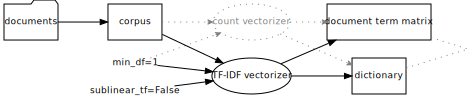

In [181]:
dot_graph('''
digraph {
  rankdir=LR;
  node [fontname="georgia; serif" fontsize=9, margin=0 arrowhead=normal arrowtail=dot];
  edge [arrowsize=0.75]

  node [shape=folder]; documents;
  node [shape=oval]; vec [label="count vectorizer", color=grey fontcolor=grey style=dotted];
      tfidf [label="TF-IDF vectorizer"];
  node [shape=plain]; min_df [label="min_df=1"]; sublinear_tf [label="sublinear_tf=False"]; dot0 [label=" "];
  node [shape=box]; dtm [label="document term matrix"]; dict [label="dictionary"];

  documents -> corpus;
  corpus -> vec [color=grey style=dotted arrowhead=vee arrowsize=0.5];
  corpus -> tfidf;
  sublinear_tf -> tfidf;
  min_df -> tfidf;
  min_df -> vec [color=grey style=dotted arrowhead=vee arrowsize=0.5];
  vec -> dtm [color=grey style=dotted arrowhead=vee arrowsize=0.5];
  tfidf -> dtm;
  vec -> dict [color=grey style=dotted arrowhead=vee arrowsize=0.5];
  tfidf -> dict;
  dtm -> dot0 [color=grey style=dotted arrowhead=none arrowsize=0.5];
  dict -> dot0 [color=grey style=dotted arrowhead=none arrowsize=0.5];
}
''')

In [182]:
# the caller is expected to select the right column from their data frame and
# pass it in as a series.
def compose_document_term_matrix(series, min_df=1, max_df=1.0, sublinear_tf=False):
    vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df, sublinear_tf=sublinear_tf)
    dt_matrix  = vectorizer.fit_transform(series)
    dictionary = vectorizer.get_feature_names_out()

    return pd.DataFrame(index=series.index, columns=dictionary, data=dt_matrix.toarray()), \
           dictionary


In [183]:
trivial_document_term_matrix, trivial_dictionary = compose_document_term_matrix(trivial_corpus['body'])
trivial_document_term_matrix


,brown,dog,fox,lazy,quick,red,slow,the,yellow
the quick brown fox,0.539313,0.000000,0.539313,0.000000,0.539313,0.000000,0.000000,0.356966,0.000000
the slow brown dog,0.497096,0.497096,0.000000,0.000000,0.000000,0.000000,0.630504,0.329023,0.000000
the quick red dog,0.000000,0.497096,0.000000,0.000000,0.497096,0.630504,0.000000,0.329023,0.000000
the lazy yellow fox,0.000000,0.000000,0.463458,0.587838,0.000000,0.000000,0.000000,0.306758,0.587838


In [184]:
trivial_topic_encodings, trivial_encoding_matrix = perform_lsa(trivial_document_term_matrix, trivial_dictionary)
trivial_topic_encodings


,topic 0,topic 1
the quick brown fox,0.814343,0.163324
the slow brown dog,0.696636,-0.382803
the quick red dog,0.696636,-0.382803
the lazy yellow fox,0.493787,0.810771


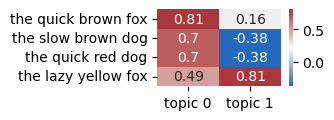

In [185]:
plt.figure(figsize=(2, 1))
sns.heatmap(trivial_topic_encodings, annot=True, cmap=CMAP_VLAG);


---
## Apply LSA to the Governance Data Set
We apply LSA to the subset _duurzaamheidsvisie_ (DV) documents from the governance data set.

### Load the DV Documents from the Governance Data

In [186]:
CACHE_DIR = '../cache/Governance'

GLOB_DV = CACHE_DIR + '/GM????DV??.txt'

# take a glob and make it iterable. We cannot use globs as objects, since these get
# "exhausted" when you iterate over them.
# https://stackoverflow.com/questions/51108256/how-to-take-a-pathname-string-with-wildcards-and-resolve-the-glob-with-pathlib
def expand_glob(glob):
    p = Path(glob)
    return Path(p.parent).expanduser().glob(p.name)

print(f"'Duurzaamheidsvisie' documents = {GLOB_DV}")

DOCUMENT_BODY = 'body'

def load_corpus_as_dataframe(glob):
    df = pd.DataFrame(data   =[file.read_text() for file in expand_glob(glob)],
                      index  =[file.stem        for file in expand_glob(glob)],
                      columns=[DOCUMENT_BODY])
    df[DOCUMENT_BODY] = df[DOCUMENT_BODY].astype(STRING)

    return df


'Duurzaamheidsvisie' documents = ../cache/Governance/GM????DV??.txt


In [187]:
corpus = load_corpus_as_dataframe(GLOB_DV)
corpus


,body
GM0003DV02,duurzaamheidsbeleid Appingedam duurzaamheidsbe...
GM0005DV01,colofon gemeente bedum bezoekadres Schoolstraa...
GM0007DV01,Milieubeleidsplan vaststellen gemeenteraad bel...
GM0009DV01,inhoud duurzaamheidsvisie februari inhoud inho...
GM0034DV01,verseonnr dagmail december raad gemeente almer...
...,...
GM1945DV01,duurzaamheidsprogramma gemeente groesbeek duur...
GM1955DV01,milieuprogramma gemeente Montferland vaststell...
GM1955DV02,notitie ruimtelijk inpassing stroomopwekking z...
GM1955DV03,energietransitienota duurzaam energie achterho...


In [188]:
corpus.info()


<class 'pandas.core.frame.DataFrame'>
Index: 248 entries, GM0003DV02 to GM1987DV01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   body    248 non-null    string
dtypes: string(1)
memory usage: 3.9+ KB


In [189]:
document_term_matrix, dictionary = compose_document_term_matrix(corpus[DOCUMENT_BODY], min_df=15, max_df=0.85, sublinear_tf=True)
document_term_matrix


,aanbested,aanbesteding,aanbestedingen,aanbestedingsbeleid,aanbestedingstraject,aanbeveling,aanbieden,aanbieder,aanbieding,aanbod,...,zuidoost,zuinig,zuiniger,zuiveren,zuivering,zwaar,zwart,zwembad,zwerfafval,zwerfvuil
GM0003DV02,0.000000,0.011893,0.000000,0.000000,0.000000,0.037606,0.029361,0.0,0.0,0.012112,...,0.0,0.032044,0.0,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
GM0005DV01,0.000000,0.014294,0.000000,0.000000,0.000000,0.000000,0.012640,0.0,0.0,0.000000,...,0.0,0.024990,0.0,0.00000,0.000000,0.000000,0.000000,0.00000,0.091208,0.000000
GM0007DV01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017399,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.00000,0.000000,0.015476,0.000000,0.00000,0.037244,0.049295
GM0009DV01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018012,0.0,0.0,0.035121,...,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.03317,0.000000,0.000000
GM0034DV01,0.000000,0.015252,0.028397,0.000000,0.000000,0.000000,0.013487,0.0,0.0,0.000000,...,0.0,0.015748,0.0,0.00000,0.031926,0.034391,0.036245,0.00000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GM1945DV01,0.000000,0.022643,0.017667,0.026563,0.045835,0.000000,0.014207,0.0,0.0,0.000000,...,0.0,0.016589,0.0,0.03323,0.000000,0.021396,0.000000,0.00000,0.000000,0.000000
GM1955DV01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022584,0.0,0.0,0.015361,...,0.0,0.000000,0.0,0.00000,0.000000,0.047936,0.000000,0.00000,0.000000,0.000000
GM1955DV02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.025917,...,0.0,0.026277,0.0,0.00000,0.000000,0.000000,0.060478,0.00000,0.000000,0.000000
GM1955DV03,0.000000,0.000000,0.000000,0.000000,0.000000,0.083714,0.013501,0.0,0.0,0.015549,...,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000


In [190]:
dictionary

array(['aanbested', 'aanbesteding', 'aanbestedingen', ..., 'zwembad',
       'zwerfafval', 'zwerfvuil'], dtype=object)

In [191]:
topic_encodings, encoding_matrix = perform_lsa(document_term_matrix, dictionary)
topic_encodings


,topic 0,topic 1
GM0003DV02,0.562004,-0.090281
GM0005DV01,0.508532,0.351052
GM0007DV01,0.540302,0.363551
GM0009DV01,0.451687,-0.106070
GM0034DV01,0.480380,-0.054353
...,...,...
GM1945DV01,0.623692,-0.039560
GM1955DV01,0.468871,0.360082
GM1955DV02,0.402342,-0.094916
GM1955DV03,0.501833,-0.095396


In [192]:
encoding_matrix

,topic 0,topic 1
aanbested,0.014093,-0.009499
aanbesteding,0.024527,0.000800
aanbestedingen,0.009186,-0.001685
aanbestedingsbeleid,0.011375,-0.007005
aanbestedingstraject,0.005298,0.001611
...,...,...
zwaar,0.015049,0.016416
zwart,0.005083,-0.005704
zwembad,0.013019,-0.007989
zwerfafval,0.020083,0.044551


In [193]:
n_most_significant("topic 0", 20, encoding_matrix)

,topic 0
eur,0.050144
afval,0.049077
maatschappelijk,0.046750
water,0.046168
programma,0.045685
wij,0.045637
natuur,0.045064
ruimtelijk,0.044887
communicatie,0.044771
mobiliteit,0.044641


In [194]:
n_most_significant("topic 1", 20, encoding_matrix)

,topic 1
gevaarlijk,0.100467
geluid,0.090528
melding,0.087459
milieutak,0.084796
veiligheid,0.084388
omgevingsvergunning,0.079903
bodemkwaliteit,0.079410
wabo,0.078485
milieubeleidsplan,0.076419
milieubeleid,0.075166


### Determine the correct number of topics using latent sementic analysis
Explained variance based on https://stackoverflow.com/questions/69091520/determine-the-correct-number-of-topics-using-latent-semantic-analysis

In [195]:
performance = []
test = range(1, 255)

for n in test: #removed the loop for reasons of performance
    svd = TruncatedSVD(n_components=n)
    lsa = svd.fit(document_term_matrix)
    performance.append(lsa.explained_variance_.sum())

(1.0, 255.0)

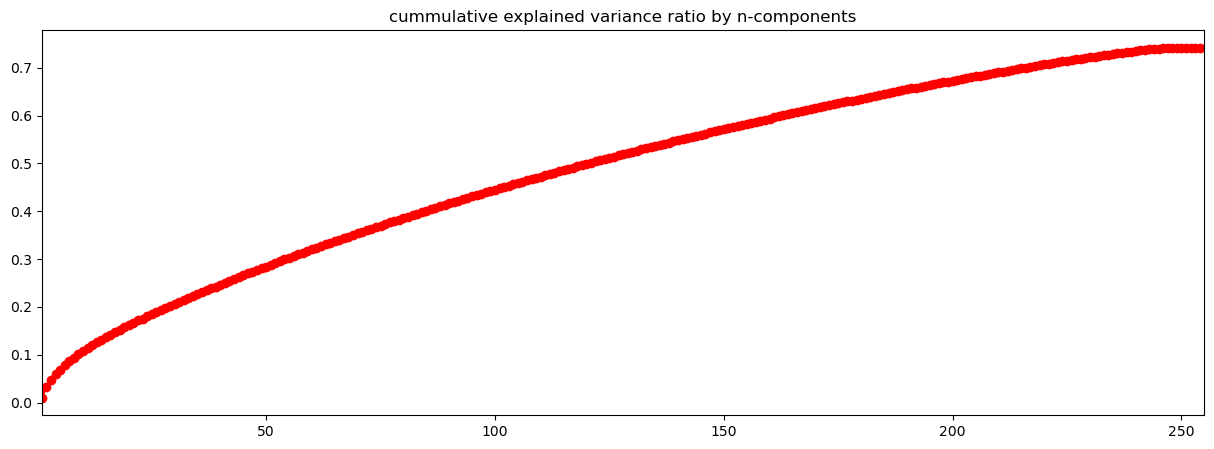

In [196]:
fig = plt.figure(figsize=(15, 5))
plt.plot(test, performance, 'ro--')
plt.title('cummulative explained variance ratio by n-components')
plt.xlim(1, 255)

70 to 80% of the explained variance ratio is reached with 125 to 150 topics.

(0.0, 25.0)

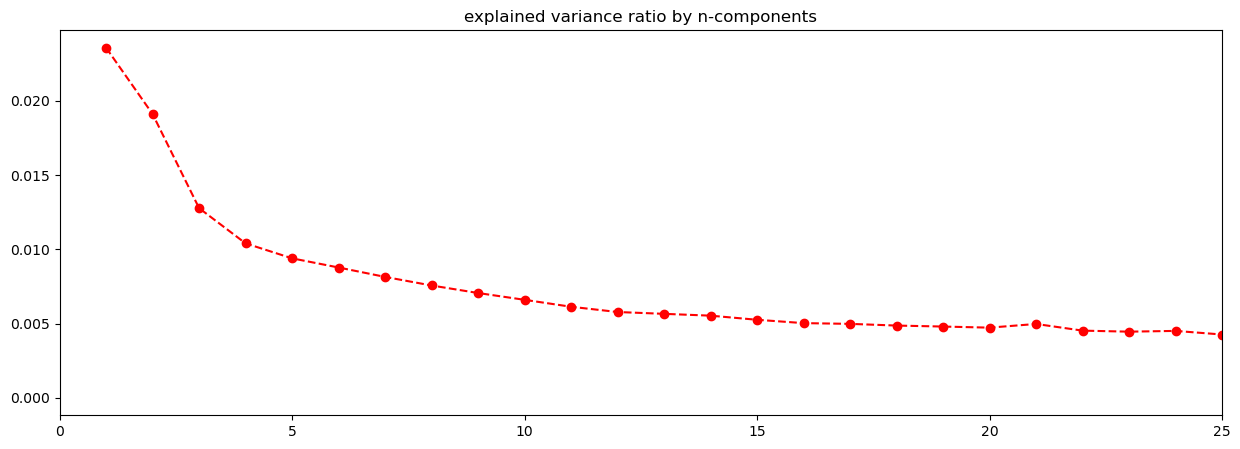

In [197]:
import numpy as np
fig = plt.figure(figsize=(15, 5))
plt.plot(test, np.gradient(performance), 'ro--')
plt.title('explained variance ratio by n-components')
plt.xlim(0, 25) # zoom to 25 to see the changes in the first components

The graph shows that the explained variance of the LSA model is about 75% at maximum of 253 topics (= number of documents). This low explained variance is probably due to the relative few but lengthy documents.
The explained variance flattens around 4 topics.

### Determining the beste parameters for the TF-IDF matrix in the LSA context
Below a matrix is constructed for different values of the min_df (absolute values) and max_df (relative values) settings for constructing the TF-IDF matrix. These are evaluated for the total explained variance and the explained variance in the first 5 topics from the LSA. Also the topic composition of the resulting topics are compared.

In [74]:
min_ls = [0, 5, 10, 15, 20, 25, 35, 50]
max_ls = [0.5, 0.75, 0.85, 0.9, 0.95, 1.0]
exvar_tot = pd.DataFrame(index=min_ls, columns=max_ls)
exvar_5 = pd.DataFrame(index=min_ls, columns=max_ls)
words = [[None] * len(max_ls)] * len(min_ls)

In [96]:
i = 0
for min_df in min_ls:
    c = 0
    for max_df in max_ls:
        document_term_matrix, dictionary = \
            compose_document_term_matrix(corpus[DOCUMENT_BODY], min_df=min_df, max_df=max_df, sublinear_tf=True)
        svd = TruncatedSVD(n_components=255)
        lsa = svd.fit(document_term_matrix)
        exvar_tot.loc[min_df, max_df] = lsa.explained_variance_.sum()
        svd = TruncatedSVD(n_components=5)
        lsa = svd.fit(document_term_matrix)
        exvar_5.loc[min_df, max_df] = lsa.explained_variance_.sum()
        words[i][c] = pd.DataFrame(lsa.components_, columns=dictionary).T
        c += 1
    i += 1

In [76]:
exvar_tot

,0.50,0.75,0.85,0.90,0.95,1.00
0,0.9303,0.896631,0.882301,0.87258,0.861839,0.846258
5,0.88263,0.832641,0.811685,0.797603,0.782147,0.759903
10,0.854773,0.796703,0.772541,0.756363,0.738668,0.71332
15,0.832447,0.768445,0.741942,0.724251,0.704951,0.677382
20,0.814704,0.746294,0.718071,0.699273,0.678809,0.649653
25,0.798824,0.726605,0.696899,0.677152,0.655698,0.625196
35,0.771139,0.692511,0.660332,0.63901,0.615923,0.583224
50,0.73258,0.645938,0.610661,0.587381,0.562287,0.526936


High total explained variances are achieved for low values of both min_df and max_df. For min_df this is the result of including words that are unique for only a few documents. For max_df it is most likely because the total number of word occurances are reduces, which reduces the total variance.

In [77]:
exvar_5

,0.50,0.75,0.85,0.90,0.95,1.00
0,0.043723,0.045425,0.045275,0.044871,0.044385,0.043844
5,0.058595,0.059473,0.058478,0.057609,0.056667,0.055311
10,0.065231,0.066244,0.064757,0.06363,0.06225,0.060449
15,0.07037,0.070831,0.068916,0.067488,0.065764,0.063626
20,0.074275,0.074217,0.071941,0.070289,0.068334,0.06587
25,0.077124,0.076568,0.073967,0.072108,0.069924,0.067178
35,0.081404,0.080101,0.076841,0.074562,0.07193,0.068645
50,0.085887,0.083287,0.079085,0.076237,0.073002,0.069061


In [143]:
exvar_rel = exvar_5 / exvar_tot
exvar_rel

,0.50,0.75,0.85,0.90,0.95,1.00
0,0.054269,0.058628,0.05934,0.059492,0.059892,0.060134
5,0.076176,0.082167,0.082848,0.083087,0.083184,0.083527
10,0.08741,0.094326,0.095044,0.095382,0.095489,0.095956
15,0.096133,0.104027,0.104795,0.105178,0.105373,0.106065
20,0.103084,0.111781,0.112721,0.113097,0.113287,0.114122
25,0.108839,0.118273,0.119194,0.119628,0.119862,0.120776
35,0.118857,0.129547,0.130565,0.130957,0.131159,0.132227
50,0.131731,0.144358,0.145243,0.145593,0.145755,0.147113


The first five topics explain most of the variance with a high max_df and low min_df. The explained variance ratio is largest at high max_df and high max_df, however this ratio reduces only slightly for medium values of max_df. So the influence of max_df is mainly influenced by the higher total explained variance. The effect of min_df is explained by less unique words for the documents (so the other topics are less able to explain variance).

In [148]:
words[3][2].sort_values(1, ascending=False)[0:20]
# (0,0) -, milieu, ruimtelijke inrichting, afval/energie, afval/energie
# (0.4) -, milieu, ruimtelijke inrichting, beleid, afval/energie
# (3,4) -, milieu, ruimtelijke inrichting, beleid, afval/energie
# (3,2) -, milieu, ruimtelijke inrichting, beleid, afval/energie
# (7,0) -, milieu, ruimtelijke inrichting, afval/energie, afval/energie
# (7,4) -, milieu, ruimtelijke inrichting, beleid, afval/energie

,0,1,2,3,4,5
eur,0.055058,-0.036298,-0.102394,0.099201,-0.002391,-0.005383
afval,0.053789,0.033590,0.029486,0.046640,0.057578,-0.087421
maatschappelijk,0.050911,-0.040379,0.035033,0.044162,-0.044550,-0.016293
water,0.050582,0.021947,0.047186,-0.011738,-0.003085,-0.047572
programma,0.050333,0.011596,-0.028066,0.072069,-0.039606,0.009476
wij,0.049847,-0.051850,0.046480,0.081964,-0.052314,0.070742
natuur,0.049430,0.034405,0.065912,0.009608,-0.022295,-0.051228
communicatie,0.049096,-0.010548,-0.011833,0.060130,-0.049817,-0.009921
ruimtelijk,0.049053,0.049421,-0.009520,-0.018043,-0.033171,-0.018043
mobiliteit,0.048528,-0.046596,0.028940,0.008052,-0.015713,-0.101144


Topic composition is influenced only slightly by different values of max_df and min_df. Low values of max_df seems to reduce the explainability of the topics.

From this analysis it can be concluded that medium values for both max_df and min_df results in a good balance between total explained variance and the explained variance of the first five topics. For our analysis it is proposed to use min_df = 15 and max_df = 0.85

### Topic assessment with 5 topics
According to the elbow method 5 topics are optimal to assess the information in the documents. Below these 5 topics are assessed for their content and value for clustering.

In [198]:
svd_dv = TruncatedSVD(n_components=5)
lsa_dv = svd_dv.fit(document_term_matrix)
lsa_docs = svd_dv.fit_transform(document_term_matrix)
lsa_dv.explained_variance_.sum()

0.06888273831127169

The first 5 topics only account for 6.6% of the explained variance between the documents.
The first 5 topics are labelled as respectively "duurzaamheid", "milieu", "ecologie", "energie" and "klimaat" according to the most important words in the topic.

In [200]:
topic_names = ["duurzaamheid","milieu","ruimtelijke inrichting","beleid","afval/energie"]
encoded_matrix = pd.DataFrame(lsa_dv.components_, index=topic_names, columns=dictionary).T
encoded_matrix.sort_values("milieu", ascending=False)[0:20] #change the column name to sort by the other topics

,duurzaamheid,milieu,ruimtelijke inrichting,beleid,afval/energie
gevaarlijk,0.022439,0.100454,-0.011506,-0.003384,-0.006146
geluid,0.031494,0.090503,0.000436,-0.013073,0.004844
melding,0.017659,0.087448,-0.027996,0.030688,-0.014499
milieutak,0.016122,0.084781,-0.025673,0.034334,0.018294
veiligheid,0.037951,0.084385,0.008122,0.003663,0.015457
omgevingsvergunning,0.018892,0.079890,-0.023778,0.022533,-0.003828
bodemkwaliteit,0.017171,0.079394,-0.013542,-0.003705,-0.001543
wabo,0.014959,0.078466,-0.028025,0.027810,0.004440
milieubeleidsplan,0.030291,0.076397,-0.017510,-0.002272,0.037476
milieubeleid,0.028932,0.075151,-0.004616,-0.005801,0.010278


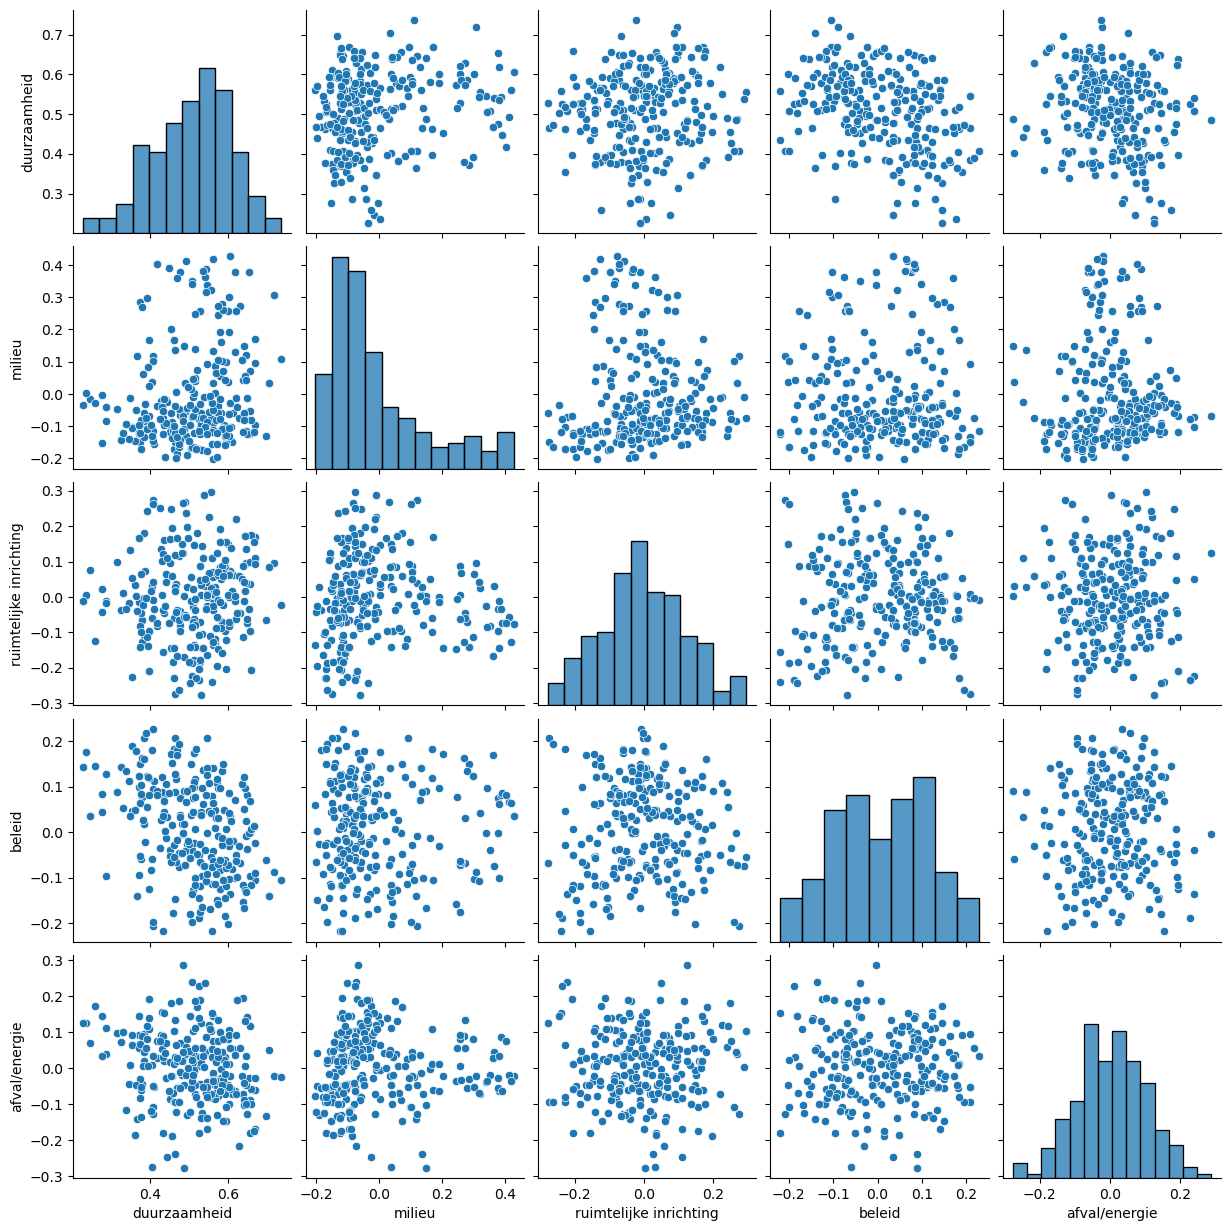

In [201]:
topics_encoded = pd.DataFrame(lsa_docs, columns=topic_names, index=corpus.index)
sns.pairplot(topics_encoded)

The first 5 topics don't show direct recognisable clusters. Most documents are pretty low on the 'milieu' topic, which indicates this topic is less mentioned in the sustainability visions. 'Energie' correlates with the first 'duurzaamheid' topic, indicating that most sustainability visions contain energy related terms.